# Imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Load data

In [17]:
# load gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED.csv 
df = pd.read_csv('data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED.csv')

In [18]:
df_prod = df[(df['type'] == 'production') & (df['meter_id']=='28ba7f57-6e83-4341-8078-232c1639e4e3')]
df_cons = df[(df['type'] == 'consumption') & (df['meter_id']=='28ba7f57-6e83-4341-8078-232c1639e4e3')]

# Summary statistics

In [19]:
df_prod_desc = df_prod["num_kwh_normalized"].describe()
df_cons_desc = df_cons["num_kwh_normalized"].describe()

# Concat series into dataframe
df_prod_cons_desc = pd.concat([df_prod_desc, df_cons_desc], axis=1)

#Change column names
df_prod_cons_desc.columns = ['Production', 'Consumption']

print(df_prod_cons_desc.to_latex())

\begin{tabular}{lrr}
\toprule
{} &    Production &   Consumption \\
\midrule
count &  23568.000000 &  23592.000000 \\
mean  &      0.008257 &      0.098455 \\
std   &      0.026861 &      0.074156 \\
min   &      0.000000 &      0.000000 \\
25\%   &      0.000000 &      0.027778 \\
50\%   &      0.000000 &      0.099278 \\
75\%   &      0.000000 &      0.138889 \\
max   &      0.166667 &      0.500000 \\
\bottomrule
\end{tabular}



C:\Users\andre\AppData\Local\Temp\ipykernel_5088\1424640167.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_prod_cons_desc.to_latex())


# Explore single meter
The one with most observations

<AxesSubplot:>

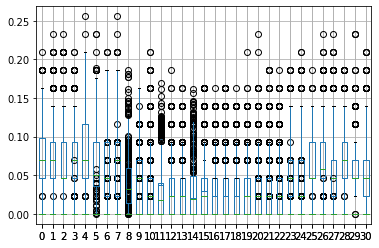

In [20]:
# Meter with most observations
mm_id = "e882f9a7-f1de-4419-9869-7339be303281"

df_mm = df[df['meter_id'] == mm_id]

df_mm_prod = df_mm[df_mm['type'] == 'production']
df_mm_cons = df_mm[df_mm['type'] == 'consumption']


df_mm_prod.index = pd.to_datetime(df_mm_prod['timeslot'], utc=True)
df_mm_cons.index = pd.to_datetime(df_mm_cons['timeslot'], utc=True)


# print(type(df_mm_prod["num_kwh_normalized"]))
# Make monthly boxplot for df_mm_prod


# groups = df_mm_prod["num_kwh_normalized"].groupby(pd.Grouper(freq='M'))
groups = df_mm_prod["num_kwh_normalized"].groupby(by=[df_mm_prod["num_kwh_normalized"].index.month, df_mm_prod["num_kwh_normalized"].index.year])

# Make boxplot of groupby object
df_mm_prod_monthly = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
df_mm_prod_monthly

df_mm_prod_monthly = pd.DataFrame(df_mm_prod_monthly)
df_mm_prod_monthly.columns = range(len(groups))
df_mm_prod_monthly.boxplot()
# df_mm_prod_monthly.boxplot()



# groups = df_mm_prod["num_kwh_normalized"].groupby(pd.Grouper(freq='M'))
groups = df_mm_cons["num_kwh_normalized"].groupby(by=[df_mm_cons["num_kwh_normalized"].index.month, df_mm_cons["num_kwh_normalized"].index.year])

# Make boxplot of groupby object
df_mm_cons_monthly = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
df_mm_cons_monthly

df_mm_cons_monthly = pd.DataFrame(df_mm_cons_monthly)
df_mm_cons_monthly.columns = range(len(groups))
df_mm_cons_monthly.boxplot()


# Centered Moving Average

In [21]:
# Centered moving average of timeseries
def moving_average(timeseries, window):
    """Calculate the moving average of a timeseries.

    Args:
        timeseries (pd.Series): timeseries
        window (int): Window size

    Returns:
        pd.Series: Smoothened timeseries
    """
    return timeseries.rolling(window=window, center=True).mean()

def plot_moving_average(timeseries, window=3, plt_title = "Moving average of consumption", y_label="Consumption (kWh)"):
    """Plot moving average of timeseries

    Args:
        timeseries (pd.Series): timeseries
        window (int): Window size
        type (str): Type, consumption or production
    """

    # Clear plot    
    plt.clf()

    cma = moving_average(timeseries, window)

    #Seaborn style plot
    sns.set(style="darkgrid")

    # # drop nan values in cma
    # cma = cma.dropna()
    # Sort cma by index
    cma = cma.sort_index()
    plt.plot(cma)
    # Add plot title
    # plt_title = f"Mo
    # ving average of {type} (Window size {window})"
    plt.title(f"{plt_title} (Window size {window})")
    # Rotate x-axis labels
    plt.xticks(rotation=75)

    # x-axis label
    plt.xlabel('Time (h)')
    # y-axis label
    plt.ylabel(y_label)

    plt.show

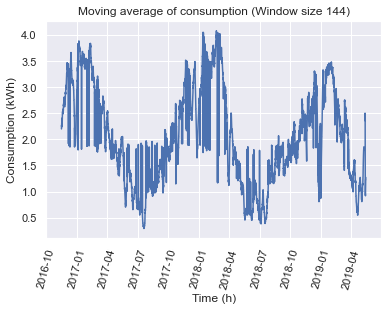

In [22]:

plot_moving_average(df_mm_cons["num_kwh"], window=12*12, plt_title="Moving average of consumption", y_label = "Consumption (kWh)")


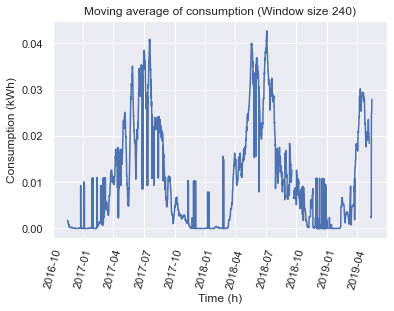

In [23]:
plot_moving_average(df_mm_prod["num_kwh_normalized"], window=12*20, plt_title="Moving average of consumption", y_label = "Consumption (kWh)")

# Seasonal decomposition of time series

In [27]:

def plot_seasonal_decomp(series, resample="W", model = "additive", title=""):
    series_resample = series.sort_index().resample("W").sum()
    decompose = seasonal_decompose(series_resample, model= model)

    plt.clf()

    if resample == "W":
        xlab = f"Time (Week)"
    else:
        xlab = f"Time ({resample})"
    ylab = "Consumption (kWh)"
    
    

    # 4 plots of decompose_cons on top of each other
    fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex = True)
    
    fig.suptitle(title, fontsize=18)
    
    ax[0].plot(decompose.observed)
    ax[0].set_title("Original time series")
    ax[1].plot(decompose.trend)
    ax[1].set_title("Trend")
    ax[1].set_ylabel("Consumption (kWh)")
    ax[2].plot(decompose.seasonal)
    ax[2].set_title("Seasonal")
    # Line in 0 behind points
    ax[3].axhline(0, color="black")
    ax[3].set_title("Residual")

    
    # Scatterplot of residuals
    ax[3].scatter(decompose.resid.index,decompose.resid)

    #Set universal xlabel
    #ax[3].set_xlabel("Time (weeks)")
    plt.xlim(pd.Timestamp('2016-09-04 00:00:00+00:00'), pd.Timestamp('2019-05-19 00:00:00+00:00'))
    
    #plt.xticks(range(0,len(decompose.resid.index)), decompose.resid.index)
    #Make titles bold font
    for i in range(4):
        ax[i].title.set_fontweight("bold")
        ax[i].set_xlabel(xlab)
        ax[i].set_ylabel(ylab)

    #Spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    plt.savefig(f"figures/methods/{title}.png")
    plt.show()

<Figure size 432x288 with 0 Axes>

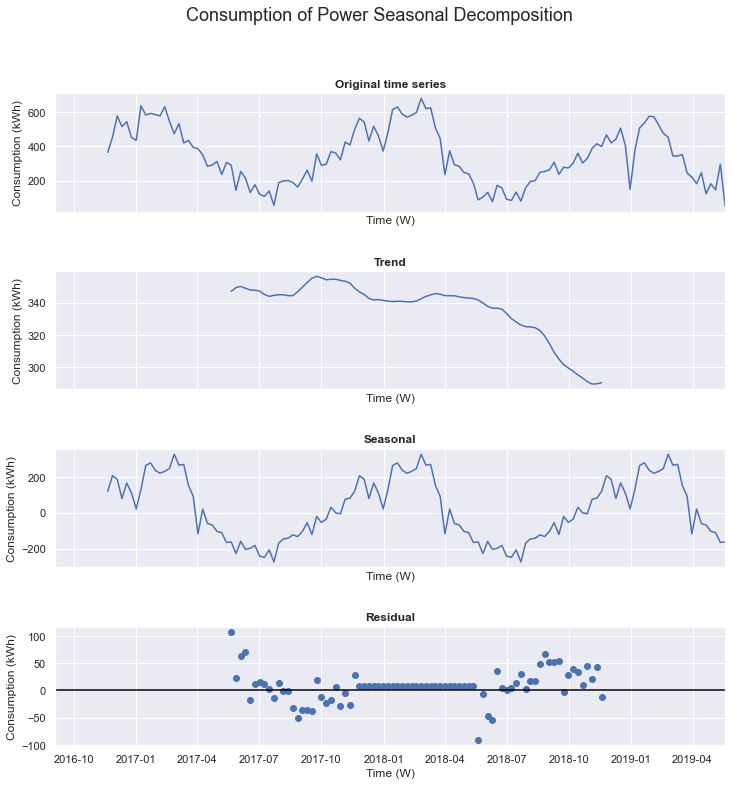

<Figure size 432x288 with 0 Axes>

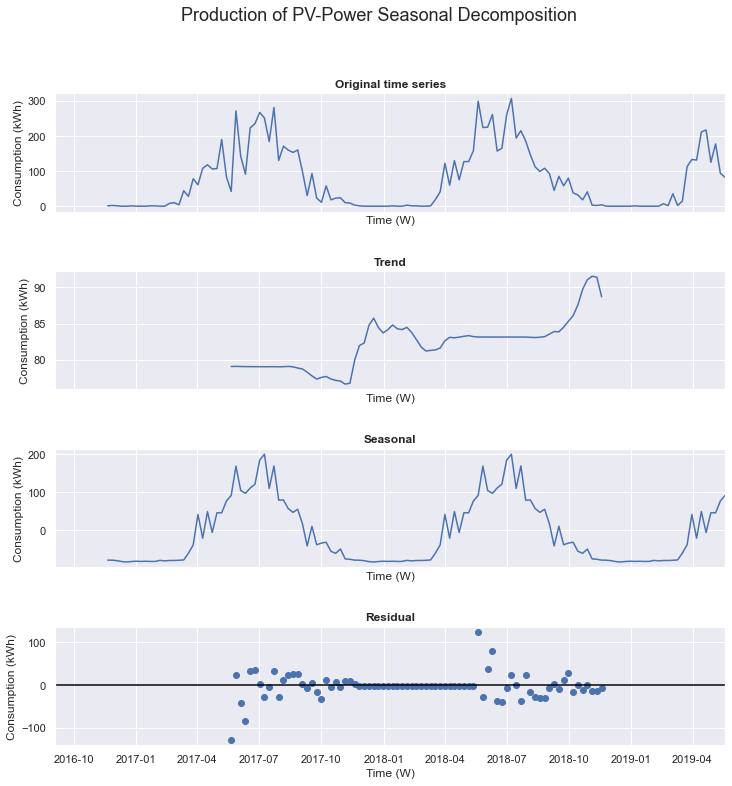

In [28]:
plot_seasonal_decomp(df_mm_cons["num_kwh"], resample="W", model = "additive", title="Consumption of Power Seasonal Decomposition")
plot_seasonal_decomp(df_mm_prod["num_kwh"], resample="W", model = "additive", title="Production of PV-Power Seasonal Decomposition")

multiplicative model for production of power

In [17]:

def plot_seasonal_decomp(series, resample="W", model = "additive", title=""):
    series = series+0.00001
    series_resample = series.sort_index().resample("W").sum()
    decompose = seasonal_decompose(series_resample, model= model)

    plt.clf()

    xlab = f"Time ({resample})"
    ylab = "Consumption (kWh)"
    
    

    # 4 plots of decompose_cons on top of each other
    fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex = True)
    
    fig.suptitle(title, fontsize=18)
    
    ax[0].plot(decompose.observed)
    ax[0].set_title("Original time series")
    ax[1].plot(decompose.trend)
    ax[1].set_title("Trend")
    ax[1].set_ylabel("Consumption (kWh)")
    ax[2].plot(decompose.seasonal)
    ax[2].set_title("Seasonal")
    # Line in 0 behind points
    ax[3].axhline(1, color="black")
    ax[3].set_title("Residual")

    
    # Scatterplot of residuals
    ax[3].scatter(decompose.resid.index,decompose.resid)

    #Set universal xlabel
    #ax[3].set_xlabel("Time (weeks)")
    plt.xlim(pd.Timestamp('2016-09-04 00:00:00+00:00'), pd.Timestamp('2019-05-19 00:00:00+00:00'))
    
    #plt.xticks(range(0,len(decompose.resid.index)), decompose.resid.index)
    #Make titles bold font
    for i in range(4):
        ax[i].title.set_fontweight("bold")
        ax[i].set_xlabel(xlab)
        ax[i].set_ylabel(ylab)

    #Spacing between subplots
    plt.subplots_adjust(hspace=0.5)
    plt.show()

<Figure size 432x288 with 0 Axes>

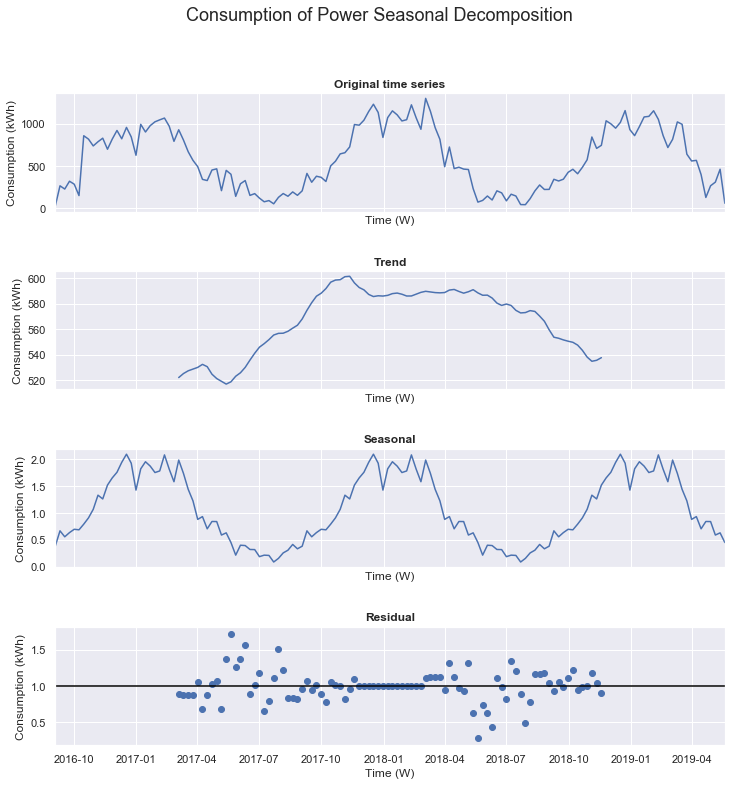

<Figure size 432x288 with 0 Axes>

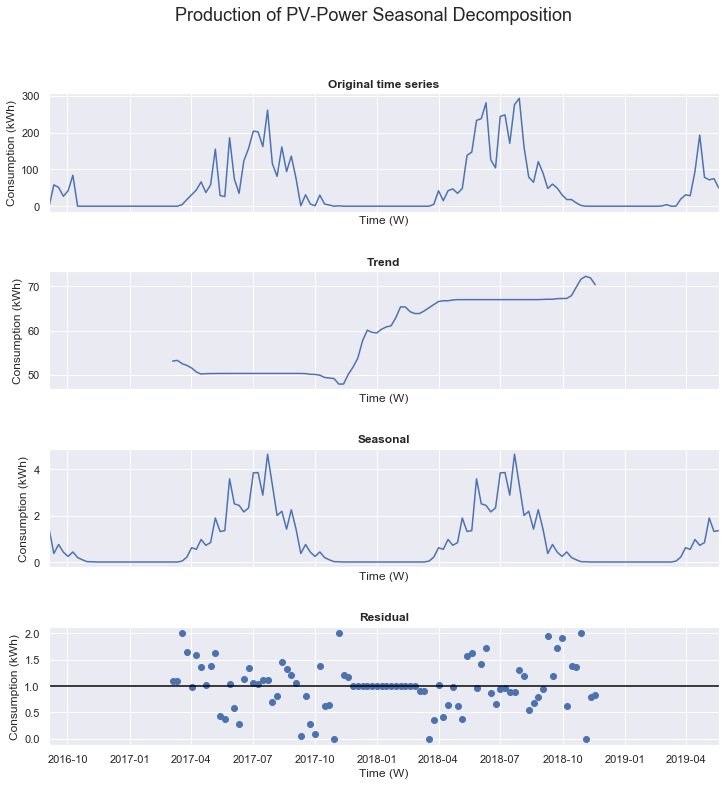

In [18]:
plot_seasonal_decomp(df_mm_cons["num_kwh"], resample="W", model = "multiplicative", title="Consumption of Power Seasonal Decomposition")
plot_seasonal_decomp(df_mm_prod["num_kwh"], resample="W", model = "multiplicative", title="Production of PV-Power Seasonal Decomposition")

plotting just residual for additive

In [25]:
def plot_seasonal_decomp(series, resample="W", model = "additive", title=""):
    series_resample = series.sort_index().resample("W").sum()
    decompose = seasonal_decompose(series_resample, model= model)

    
    plt.scatter(decompose.resid.index,decompose.resid)
    #Set universal xlabel
    #ax[3].set_xlabel("Time (weeks)")
    plt.xlim(pd.Timestamp('2016-09-04 00:00:00+00:00'), pd.Timestamp('2019-05-19 00:00:00+00:00'))
    plt.xlab = f"Time ({resample})"
    plt.ylab = "Consumption (kWh)"
    #plt.xticks(range(0,len(decompose.resid.index)), decompose.resid.index)
    #Make titles bold font
        
    plt.axhline(0, color="black")
    plt.title("Residual") 

    #Spacing between subplots
    plt.subplots_adjust(hspace=0.5)
    plt.show()

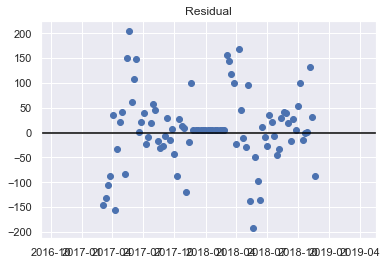

In [26]:
plot_seasonal_decomp(df_mm_cons["num_kwh"], resample="W", model = "additive", title="Consumption of Power Seasonal Decomposition")